In [18]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
import numpy as np
from pathlib import Path
import re
import scipy
from scipy.special import factorial
from scipy import spatial
import skfem
import sys
import time
from tqdm.notebook import tqdm

import eit

datadir = Path("../data/")
figdir = Path("../docs/figures/")

In [38]:
with open("../docs/paper_1/paper_1_tool_versions.tex", "w") as f:
    f.write("\\newcommand{\\PYTHONVER}{{v__VERSION__}}\n".replace("__VERSION__", sys.version.split()[0]))
    f.write("\\newcommand{\\NUMPYVER}{{v__VERSION__}}\n".replace("__VERSION__", np.__version__))
    f.write("\\newcommand{\\SCIPYVER}{{v__VERSION__}}\n".replace("__VERSION__", scipy.__version__))
    f.write("\\newcommand{\\SKFEMVER}{{v__VERSION__}}\n".replace("__VERSION__", skfem.__version__))
with open("../docs/paper_1/paper_1_tool_versions.tex", "r") as f:
    print(f.read())


\newcommand{\PYTHONVER}{{v3.10.6}}
\newcommand{\NUMPYVER}{{v1.23.3}}
\newcommand{\SCIPYVER}{{v1.9.1}}
\newcommand{\SKFEMVER}{{v7.0.1}}



In [ ]:
python", sys.version.split()[0])
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print("skfem", skfem.__version__)


In [2]:
mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.subplot.left'] = 0
mpl.rcParams['figure.subplot.right'] = 1
mpl.rcParams['figure.subplot.top'] = 1
mpl.rcParams['figure.subplot.bottom'] = 0

# Example Arrays

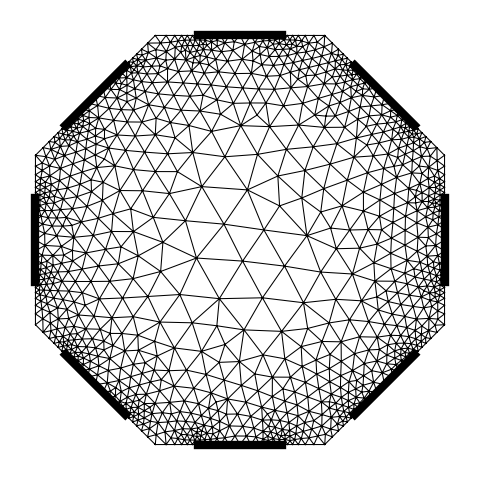

In [3]:
mesh8 = datadir/"N08_LN01_A050_H025.msh"
basis8 = eit.build_basis(mesh8)
fig, ax = plt.subplots(figsize=(3,3))
ax.axis("off")
basis8[0].p0.mesh.draw(ax=ax)
eit.add_electrodes(ax, 8, 1, 0.5)
fig.savefig(figdir/"example_array_8.png")

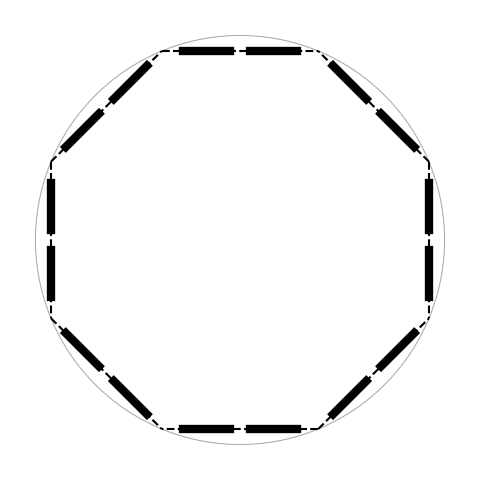

In [4]:
mesh8_2 = eit.build_polygonal_mesh(8, 2, .5, .25, "../data/")
basis8_2 = eit.build_basis(mesh8_2)
p0 = eit.build_basis(mesh8_2)[0].p0

fig, ax = plt.subplots(figsize=(3,3))
ax.axis("off")
t = np.linspace(0, 2*np.pi, 200)
ax.plot(np.cos(t), np.sin(t), color="#AAAAAA", lw=.5)
for simplex in spatial.ConvexHull(p0.mesh.p.T).simplices:
    ax.plot(p0.mesh.p.T[simplex, 0], p0.mesh.p.T[simplex, 1], 'k--', lw=1)
eit.add_electrodes(ax, 8, 2, 0.6)
fig.savefig(figdir/"example_array_16_no_mesh.png")

# Convergence of 1st order Jacobian Approximation

In [5]:
S_list = list()
D_list = list()
deltas = list()
J0 = None
for file in tqdm(list(datadir.glob("N08_LN01_A050_H025.D*.h5"))):
    with h5py.File(file, "r") as h5:
        J = h5["J"][:]
    if J0 is None:
        J0 = J.copy()
    _,S,_ = np.linalg.svd(J)
    delta = int(re.search("D[0-9]+", file.stem)[0][1:])/10000
    deltas.append(delta)
    S_list.append(S)
    D_list.append(np.linalg.norm(J-J0))

delta = np.array(deltas)
sort = delta.argsort()
delta = delta[sort]
S = np.array(S_list)[sort]
D = np.array(D_list)[sort]

  0%|          | 0/101 [00:00<?, ?it/s]

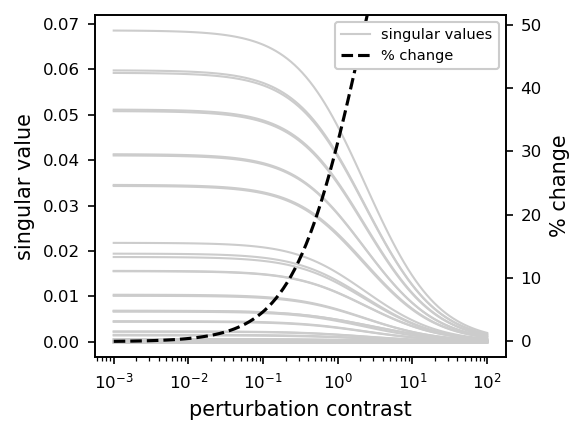

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
ax2 = ax.twinx()
ax2.set_ylim(-2.5, 51.5)
ax.set_xlabel("perturbation contrast")
ax.set_ylabel("singular value")
ax2.set_ylabel("% change")
lines = ax.semilogx(delta, S, color="#CCC", lw=1)
lines += ax2.plot(delta, D/np.linalg.norm(J0)*100, ls="--", color="#000")
plt.legend([lines[0], lines[-1]], ["singular values", "% change"], loc=1, framealpha=1, fontsize=7)
plt.tight_layout()
fig.savefig("../docs/figures/jacobian_convergence_8.png")

# Plots of singular values sizes

In [7]:
mesh = Path("../data/N08_LN01_A050_H020.msh")
with h5py.File(mesh.with_suffix(".D100.h5"), "r") as h5:
    J8 = h5["J"][:]
mesh = Path("../data/N16_LN01_A050_H020.msh")
p0 = eit.build_basis(mesh)[0].p0
with h5py.File(mesh.with_suffix(".D100.h5"), "r") as h5:
    J16 = h5["J"][:]

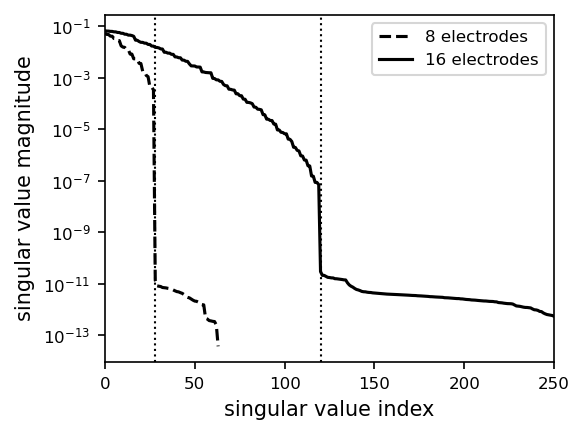

In [8]:
fig, ax = plt.subplots()
_, S8, _ = np.linalg.svd(J8)
ax.semilogy(S8, "k--", label="8 electrodes")
_, S16, _ = np.linalg.svd(J16)
ax.semilogy(S16, "k", label="16 electrodes")
ax.axvline(28, lw=1, ls=":", color="k")
ax.axvline(120, lw=1, ls=":", color="k")
ax.set_xlabel("singular value index")
ax.set_ylabel("singular value magnitude")
ax.set_xlim(0,250)
plt.legend()
plt.tight_layout()
plt.savefig("../docs/figures/singular_values.png")

# Model Basis Functions

In [9]:
mesh = datadir/"N08_LN01_A033_H0070.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]
U, S, Vt = np.linalg.svd(J)

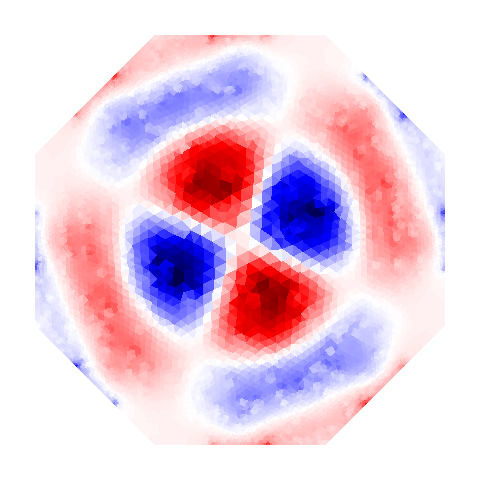

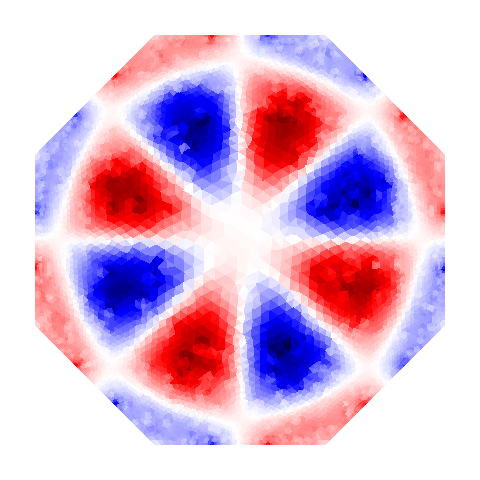

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
p0.plot(Vt[t[-2]], cmap="seismic", ax=ax)
ax.axis("off")
plt.savefig(figdir/"model_basis_n8a.png")
fig, ax = plt.subplots(figsize=(3,3))
p0.plot(Vt[t[-4]], cmap="seismic", ax=ax)
ax.axis("off")
plt.savefig(figdir/"model_basis_n8b.png")

In [11]:
mesh = datadir/"N16_LN01_A033_H0070.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]
U, S, Vt = np.linalg.svd(J)

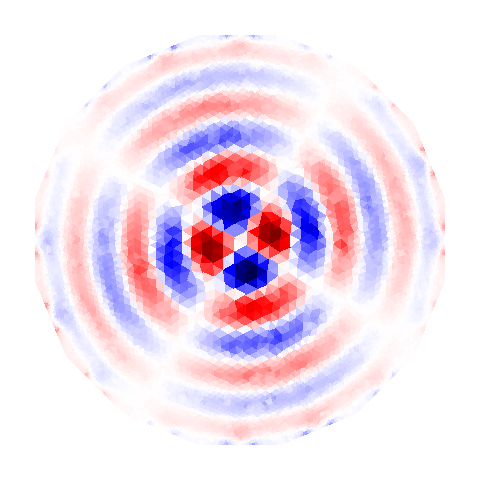

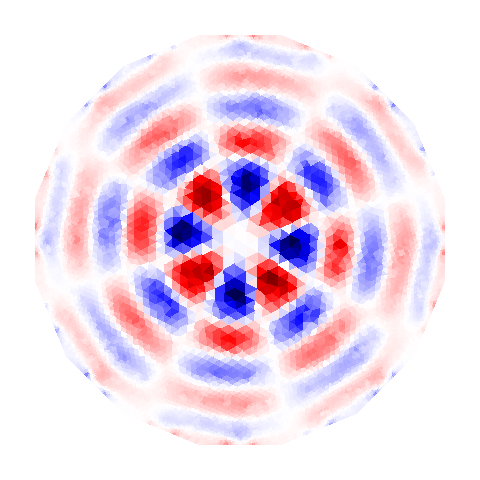

In [12]:
fig, ax = plt.subplots(figsize=(3,3))
ax.axis("off")
p0.plot(Vt[t[-2]], cmap="seismic", ax=ax)
plt.savefig(figdir/"model_basis_n16a.png")
fig, ax = plt.subplots(figsize=(3,3))
ax.axis("off")
p0.plot(Vt[t[-4]], cmap="seismic", ax=ax)
plt.savefig(figdir/"model_basis_n16b.png")

# Linearity Analysis

In [13]:
mesh = datadir/"N08_LN01_A033_H0200.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]
    
r_list = np.sqrt(np.linspace(.1, .5, 20))
s0 = np.ones(p0.N)
U0 = eit.measure(basis, s0)
data = list()
for r in tqdm(r_list):
    ds = np.zeros(p0.N)
    ds[p0.get_dofs(elements=lambda x: np.sqrt(x[0]**2 + x[1]**2) < r)] = 1
    ds_area = eit.moment(p0, ds)
    ds *= 0.1
    U1 =  eit.measure(basis, s0 + ds)
    err = U1 - U0 - J @ ds
    Linf_i = abs(err).argmax()
    data.append([r, ds_area, abs(err[Linf_i]), abs(J@ds)[Linf_i]])
data1 = np.array(data)

r_list = np.sqrt(np.linspace(.1, .5, 20))
s0 = np.ones(p0.N)
U0 = eit.measure(basis, s0)
data = list()
for r in tqdm(r_list):
    ds = np.zeros(p0.N)
    ds[p0.get_dofs(elements=lambda x: np.sqrt(x[0]**2 + x[1]**2) < r)] = 1
    ds_area = eit.moment(p0, ds)
    ds *= .01
    U1 =  eit.measure(basis, s0 + ds)
    err = U1 - U0 - J @ ds
    Linf_i = abs(err).argmax()
    data.append([r, ds_area, abs(err[Linf_i]), abs(J@ds)[Linf_i]])
data2 = np.array(data)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

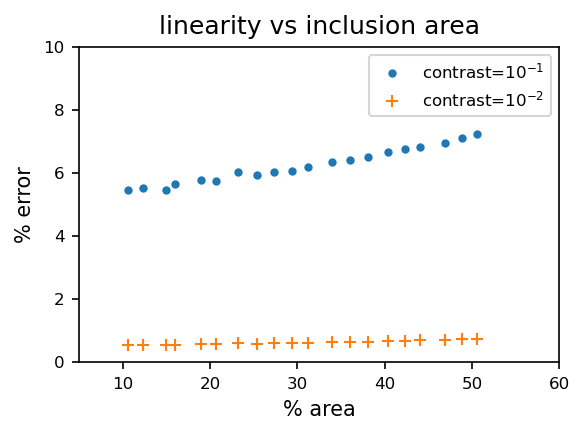

In [35]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(100*data1[:,1]/a, 100*data1[:,2]/abs(data1[:,3]), '.', label="contrast=$10^{-1}$")
ax.plot(100*data2[:,1]/a, 100*data2[:,2]/abs(data2[:,3]), '+', label="contrast=$10^{-2}$")
ax.set_title("linearity vs inclusion area")
ax.set_xlabel("% area")
ax.set_ylabel("% error")
ax.set_ylim(0,10)
ax.set_xlim(5,60)
ax.legend()
fig.tight_layout()
fig.savefig(figdir/"linearity_vs_size_8.png")

In [19]:
mesh = datadir/"N08_LN01_A033_H0200.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    J = h5["J"][:]
    t = h5["t"][:]

    
c_list = np.logspace(np.log10(.001), np.log10(1), 50)
s0 = np.ones(p0.N)
U0 = eit.measure(basis, s0)
data = list()
for c in tqdm(c_list):
    ds = np.zeros(p0.N)
    ds[p0.get_dofs(elements=lambda x: np.sqrt(x[0]**2 + x[1]**2) < np.sqrt(a*.1/np.pi))] = 1
    ds_area = eit.moment(p0, ds)
    ds *= c
    U1 =  eit.measure(basis, s0 + ds)
    err = U1 - U0 - J @ ds
    Linf_i = abs(err).argmax()
    data.append([c, ds_area, abs(err[Linf_i]), abs(J@ds)[Linf_i]])
data3 = np.array(data)

s0 = np.ones(p0.N)
U0 = eit.measure(basis, s0)
data = list()
for c in tqdm(c_list):
    ds = np.zeros(p0.N)
    ds[p0.get_dofs(elements=lambda x: np.sqrt(x[0]**2 + x[1]**2) < np.sqrt(a*.5/np.pi))] = 1
    ds_area = eit.moment(p0, ds)
    ds *= c
    U1 =  eit.measure(basis, s0 + ds)
    err = U1 - U0 - J @ ds
    Linf_i = abs(err).argmax()
    data.append([c, ds_area, abs(err[Linf_i]), abs(J@ds)[Linf_i]])
data4 = np.array(data)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

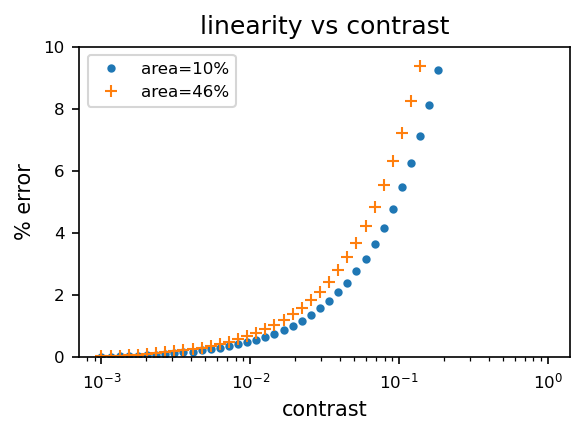

In [36]:
fig, ax = plt.subplots(figsize=(4,3))
ax.semilogx(data3[:,0], 100*data3[:,2]/abs(data3[:,3]), '.', label=f"area={100*data3[0][1] / a:.0f}%")
ax.semilogx(data4[:,0], 100*data4[:,2]/abs(data4[:,3]), '+', label=f"area={100*data4[0][1] / a:.0f}%")
ax.set_ylim(0,10)
ax.set_title("linearity vs contrast")
ax.set_xlabel("contrast")
ax.set_ylabel("% error")
ax.legend()
plt.tight_layout()
fig.savefig("../docs/figures/linearity_vs_contrast_8.png")

# Point spread functions

In [38]:
vmin, vmax = -.00, .05
pt = [.2, .0]
data = list()
cmap = "Reds"
circ_t = np.linspace(0, np.pi*2, 200)
circ_x = np.cos(circ_t)
circ_y = np.sin(circ_t)

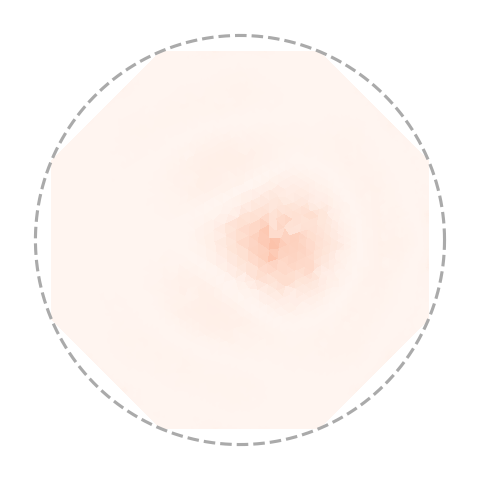

In [39]:
mesh = datadir/"N08_LN01_A033_H0070.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]

U, S, Vt = np.linalg.svd(J)
MRM = Vt[t].T @ Vt[t]

dof = eit.get_dof(basis[0].p0, pt)

data.append([p0, MRM[dof]])
fig, ax = plt.subplots(figsize=(3, 3))
ax.axis("off"); ax.set_aspect(1); ax.set_title("");
basis[0].p0.plot(abs(MRM[dof]), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax.plot(circ_x, circ_y, "--", color="#AAA")
fig.savefig("../docs/figures/psf_8.png")

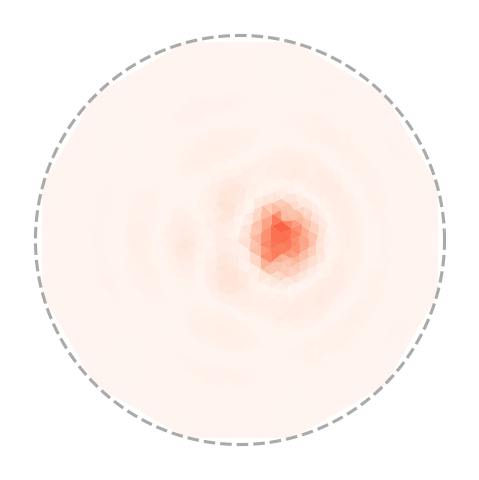

In [40]:
mesh = datadir/"N12_LN01_A033_H0070.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]

U, S, Vt = np.linalg.svd(J)
MRM = Vt[t].T @ Vt[t]


dof = eit.get_dof(basis[0].p0, pt)

data.append([p0, MRM[dof]])

fig, ax = plt.subplots(figsize=(3, 3))
ax.axis("off"); ax.set_aspect(1); ax.set_title("");
basis[0].p0.plot(abs(MRM[dof]), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax.plot(circ_x, circ_y, "--", color="#AAA")
fig.savefig("../docs/figures/psf_12.png")

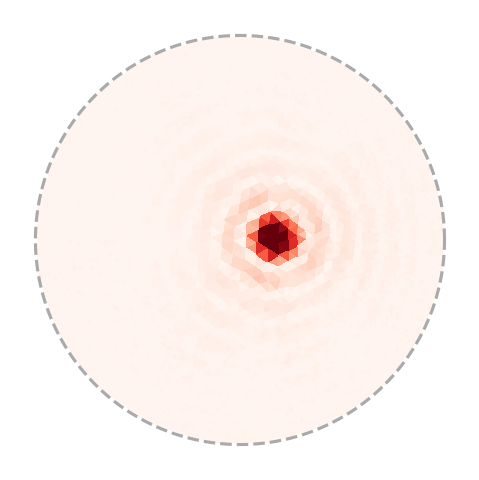

In [41]:
mesh = datadir/"N20_LN01_A033_H0070.msh"
basis = eit.build_basis(mesh)
p0 = basis[0].p0
with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
    N = h5.attrs["number_sides"]
    a = h5.attrs["mesh_area"]    
    J = h5["J"][:]
    t = h5["t"][:]

U, S, Vt = np.linalg.svd(J)
MRM = Vt[t].T @ Vt[t]


dof = eit.get_dof(basis[0].p0, pt)

data.append([p0, MRM[dof]])

fig, ax = plt.subplots(figsize=(3, 3))
ax.axis("off"); ax.set_aspect(1); ax.set_title("");
basis[0].p0.plot(abs(MRM[dof]), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax.plot(circ_x, circ_y, "--", color="#AAA")
fig.savefig("../docs/figures/psf_20.png")

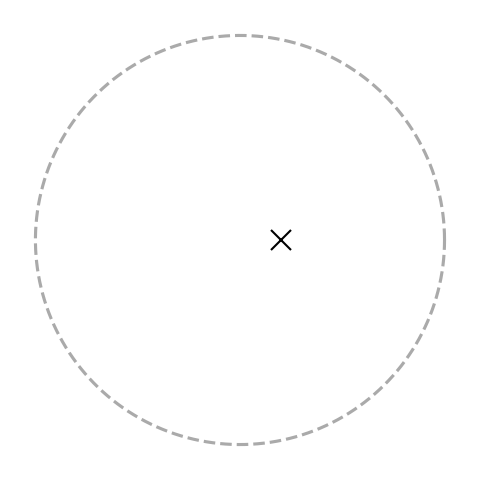

In [33]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.axis("off"); ax.set_aspect(1); ax.set_title("");
ax.plot(circ_x, circ_y, "--", color="#AAA")
ax.plot(pt[0], pt[1], "xk", markersize=10)
fig.savefig("../docs/figures/psf_location.png")

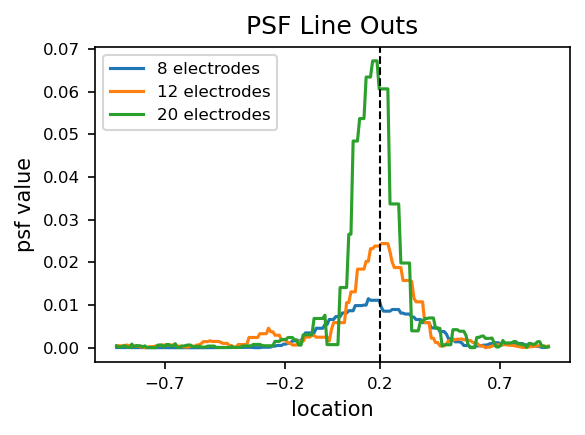

In [44]:
labels = ["8", "12", "20"]
fig, ax = plt.subplots(figsize=(4, 3))
pts = np.linspace(-.9, .9, 200)
for l, d in zip(labels, data):
    prb = d[0].probes(np.vstack([pts, np.zeros_like(pts)]))
    ax.plot(pts, prb @ abs(d[1]), label=f"{l} electrodes")
ax.legend()
ax.axvline(pt[0], color="k", ls="--", lw=1)
ax.set_xticks([-.7, -.2, .2, .7,])
ax.set_ylabel("psf value")
ax.set_xlabel("location")
ax.set_title("PSF Line Outs")
plt.tight_layout()
fig.savefig("../docs/figures/psf_lines.png")

# Radius of Reoslution

In [ ]:
meshes = [
    datadir/"N04_LN01_A033_H0070.msh",
    datadir/"N08_LN01_A033_H0070.msh",
#    datadir/"N12_LN01_A033_H0070.msh",
    datadir/"N16_LN01_A033_H0070.msh",
    datadir/"N20_LN01_A033_H0070.msh",
]
aa = np.linspace(0, 2*np.pi, 200)
b0, b1 = np.cos(aa), np.sin(aa)
data = list()
fig, axes = plt.subplots(len(meshes), 4, figsize=(15.1, 15/3*len(meshes)),
                        gridspec_kw={"width_ratios" : [.1,1,1,1]})

for ax_, mesh in zip(axes, tqdm(meshes)):
    ax_[0].axis("off")
    ax_[0].annotate(f"{int(mesh.stem[1:3])}", (.5,.5), fontsize=30)
    ax = ax_[1:]
    basis = eit.build_basis(mesh)
    p0 = basis[0].p0
    with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
        N = h5.attrs["number_sides"]
        area = h5.attrs["mesh_area"]
        ror = h5["ror"][:]*3
        J = h5["J"][:]
        t = h5["t"][:]
    U, S, Vt = np.linalg.svd(J)
    MRM = Vt[t].T @ Vt[t]
    Sinv = np.zeros_like(J.T)
    Sinv[t,t] = 1/S[t]
    Jinv = Vt.T @ Sinv @ U.T
    i = eit.get_dof(p0, (0,0))
    s0 = np.ones(p0.N)
    ds = np.zeros(p0.N)
    ds[p0.get_dofs(elements=lambda x: np.sqrt(x[0]**2 + x[1]**2) <= ror[i])] = .1
    U0 = eit.measure(basis, s0)
    U1 = eit.measure(basis, s0 + ds)
    ds1 = Jinv @ (U1 - U0)
    ax[0].axis("off"); ax[0].set_aspect(1)
    ax[1].axis("off"); ax[1].set_aspect(1)
    ax[2].axis("off"); ax[2].set_aspect(1)
    ax[2].plot(b0, b1, color="#555", lw=1, ls="--")

    ax[0].set_xlim(-1.05, 1.05); ax[0].set_ylim(-1.05, 1.05)
    ax[0].plot(b0, b1, color="#555", lw=1, ls="--")
    ax[1].set_xlim(-1.05, 1.05); ax[1].set_ylim(-1.05, 1.05)
    ax[1].plot(b0, b1, color="#555", lw=1, ls="--")
    # ax[2].axis("off"); ax[2].set_aspect(1)
    # ax[3].axis("off"); ax[3].set_aspect(1)
    p0.plot(ror, vmin=0, vmax=.3, ax=ax[0])
    p0.plot(abs(ds1), ax=ax[1], vmin=0.0, vmax=.075, cmap="viridis")
    ax[1].add_patch(Circle((0, 0), ror[i], fill=False, color="r", lw=3, ls="--"))
    # p0.plot(ds1, ax=ax[2], vmin=0, vmax=.1)
    # p0.plot(ds, ax=ax[3], vmin=0, vmax=.1)
    pts = np.linspace(-.7, .7, 200)
    prb = p0.probes(np.vstack([pts, np.zeros_like(pts)]))
    c1 = prb @ ds
    c2 = prb @ ds1
    twn = ax[2].twinx()
    twn.axis("off")
    twn.set_ylim(-.14, .14)
    twn.plot(pts, c1, "k--", lw=2)
    twn.plot(pts, c2, "b", lw=2)
    ax[1].plot(np.linspace(-.7, .7, 200), np.zeros(200), lw=2, ls="--", color="#EEE")
    data.append([N, area, p0, ror])

plt.tight_layout()
fig.savefig(figdir/"radius_of_resolution.png")


fig, ax = plt.subplots(1, 5, figsize=(15, 1),
                       gridspec_kw={"width_ratios" : [.3,.7,.15,.7,1.05]})

ax[0].axis("off")
ax[1].imshow([np.linspace(0, 1, 200)]*10, extent=(0, .3, 0, .03), cmap="jet")
ax[1].set_aspect(1)
ax[1].yaxis.set_visible(False)
ax[1].set_xticks([0, .3])
ax[1].tick_params(axis='x', labelsize=20)



ax[2].axis("off")
ax[3].imshow([np.linspace(0, 1, 200)]*10, extent=(0, .08, 0, .008), cmap="viridis")
ax[3].set_aspect(1)
ax[3].yaxis.set_visible(False)
ax[3].set_xticks([0, .08])
ax[3].tick_params(axis='x', labelsize=20)

ax[4].axis("off")

plt.tight_layout()
fig.savefig(figdir/"radius_of_resolution_scale.png")

# Figure of Merit

In [ ]:
meshes = [
    datadir/"N04_LN01_A033_H0070.msh",
    datadir/"N08_LN01_A033_H0070.msh",
    datadir/"N12_LN01_A033_H0070.msh",
    datadir/"N16_LN01_A033_H0070.msh",
    datadir/"N20_LN01_A033_H0070.msh",
]


data = list()
for mesh in tqdm(meshes):
    basis = eit.build_basis(mesh)
    p0 = basis[0].p0
    with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
        N = h5.attrs["number_sides"]
        area = h5.attrs["mesh_area"]
        ror = h5["ror"][:]*3
    data.append([N, area, p0, ror])

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))


L = [d[0] for d in data]
avg = np.array([eit.moment(d[2], d[3])/d[1] for d in data])
std = np.array([eit.moment(d[2], abs(d[3]-avg_))/d[1] for d, avg_ in zip(data, avg)])
mi = np.array([d[3].min() for d in data])
ma = np.array([d[3].max() for d in data])


e1 = avg+std
e1 = (ma - e1) / 2 + e1
e2 = (ma - (avg+std)) / 2
eb = plt.errorbar(L, e1, e2, ecolor="#AAA", fmt="none", capsize=5, markersize=5)
eb[-1][0].set_linestyle("--")
e1 = avg-std
e1 = (e1-mi) / 2 + mi
e2 = (avg-std-mi) / 2
eb = plt.errorbar(L, e1, e2, ecolor="#AAA", fmt="none", capsize=5, markersize=5)
eb[-1][0].set_linestyle("--")
plt.errorbar(L, avg, std, fmt="sk", capsize=5, markersize=5)
plt.plot([], "sk", label="average", markersize=4)
plt.plot([], "k", label="± 1 std dev")
plt.plot([], "--", color="#AAA", label="min/max")
ax.legend()
ax.set_xlim(2, 22)
ax.set_xticks([4, 8, 12, 16, 20])
ax.set_ylabel("radius of resolution")
ax.set_xlabel("# electrodes")
plt.tight_layout()
fig.savefig(figdir/"merit_vs_L.png")

In [26]:
meshes = [
    datadir/"N16_LN01_A005_H0070.msh",
    datadir/"N16_LN01_A015_H0070.msh",
    datadir/"N16_LN01_A025_H0070.msh",
    datadir/"N16_LN01_A033_H0070.msh",
    datadir/"N16_LN01_A050_H0070.msh",
    datadir/"N16_LN01_A066_H0070.msh",
    datadir/"N16_LN01_A075_H0070.msh",
    datadir/"N16_LN01_A085_H0070.msh",
    datadir/"N16_LN01_A095_H0070.msh",
]
data = list()
data = list()
for mesh in tqdm(meshes):
    basis = eit.build_basis(mesh)
    p0 = basis[0].p0
    with h5py.File(mesh.with_suffix(".D10.h5")) as h5:
        N = h5.attrs["number_sides"]
        area = h5.attrs["mesh_area"]
        ror = h5["ror"][:]*3
    data.append([N, area, p0, ror])
    

  0%|          | 0/9 [00:00<?, ?it/s]

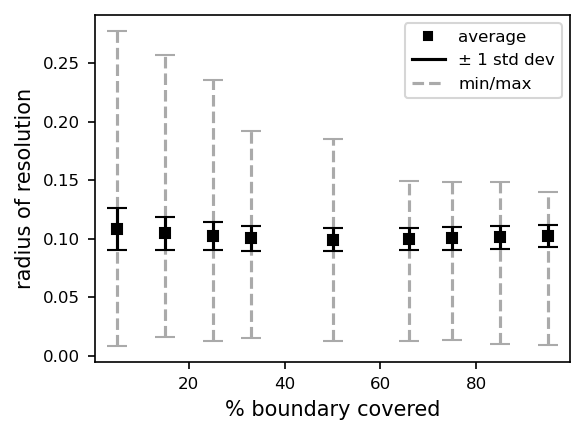

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))

a = np.array([.05, .15, .25, .33, .5, .66, .75, .85, .95])
avg = np.array([eit.moment(d[2], d[3])/d[1] for d in data])
std = np.array([eit.moment(d[2], abs(d[3]-avg_))/d[1] for d, avg_ in zip(data, avg)])
mi = np.array([d[3].min() for d in data])
ma = np.array([d[3].max() for d in data])


e1 = avg+std
e1 = (ma - e1) / 2 + e1
e2 = (ma - (avg+std)) / 2
eb = plt.errorbar(100*a, e1, e2, ecolor="#AAA", fmt="none", capsize=5, markersize=5)
eb[-1][0].set_linestyle("--")
e1 = avg-std
e1 = (e1-mi) / 2 + mi
e2 = (avg-std-mi) / 2
eb = plt.errorbar(100*a, e1, e2, ecolor="#AAA", fmt="none", capsize=5, markersize=5)
eb[-1][0].set_linestyle("--")
plt.errorbar(100*a, avg, std, fmt="sk", capsize=5, markersize=5)
plt.plot([], "sk", label="average", markersize=4)
plt.plot([], "k", label="± 1 std dev")
plt.plot([], "--", color="#AAA", label="min/max")
ax.legend()
ax.set_ylabel("radius of resolution")
ax.set_xlabel("% boundary covered")
plt.tight_layout()
fig.savefig(figdir/"merit_vs_alpha.png")

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

a = np.array([.05, .15, .25, .33, .5, .66, .75, .85, .95])
avg = [eit.moment(d[2], d[3])/eit.moment(d[2], np.ones(d[2].N)) for d in data]
ax.plot(
    100*a,
    [eit.moment(d[2], abs(d[3]-avg_)) for d, avg_ in zip(data, avg)],
    'o', markersize=6, label="average")


ax.legend()
ax.set_ylabel("radius of resolution")
ax.set_xlabel("% boundary covered")
plt.tight_layout()
fig.savefig(figdir/"merit_vs_alpha.png")

In [ ]:
a = np.array([.05, .15, .25, .33, .5, .66, .75, .85, .95])
avg = [eit.moment(d[2], d[3])/d[1] for d in data]
std = [eit.moment(d[2], abs(d[3]-avg_))/d[1] for d, avg_ in zip(data, avg)]
min_ = [d[3].min() for d in data]
max_ = [d[3].max() for d in data]
plt.errorbar(a, avg, std, fmt="sk", capsize=5, markersize=5)
plt.plot(a, max_, "sr")
plt.plot(a, min_, "sb")